<center>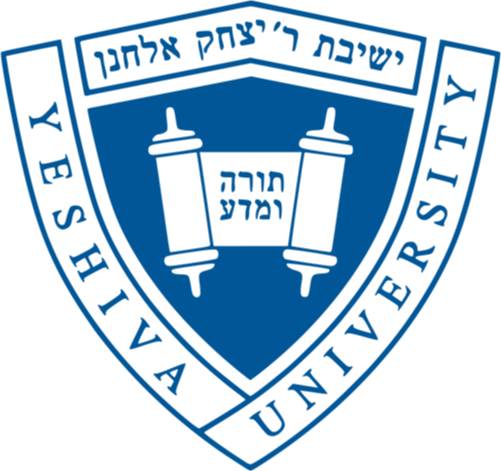</center>

<h1 style='text-align: center;'>Katz School of Science and Health</h1>
<h1 style='text-align: center;'>AIM 5005 Neural Networks and Deep Learning</h1>
<p>
<h2 style='text-align: center;'>Final Project</h1>
<br><br>
<h2 style='text-align: center;'>Enhanced Analysis of Gastrointestinal Imaging: A Focus on VQA and Segmentation</h1>
<br><br>

<div style="display: flex; justify-content: center;">
    <table style="border-collapse: collapse; border: 0;">
        <tr>
            <td style="text-align:center; vertical-align:middle; padding:10px 40px 10px 10px; border: 0;">
                <h3 style="margin: 0;">Sheng-Han Yueh</h3>
            </td>
            <td style="text-align:center; vertical-align:middle; padding:10px 10px 10px 40px; border: 0;">
                <h3 style="margin: 0;">Radek Jan Holik</h3>
            </td>
        </tr>
    </table>
</div>
<br>
<br>
<br>

# Paper link:
https://www.researchgate.net/publication/370715107_Enhanced_Analysis_of_Gastrointestinal_Imaging_A_Focus_on_VQA_and_Segmentation

# __Package import__

In [1]:
import platform
import pandas as pd
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset,DataLoader, random_split
from torchvision import datasets, transforms
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from PIL import Image
import random
import os
import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

from IPython.display import clear_output

from datetime import datetime, timedelta
from timeit import default_timer as timer

from transformers import GPT2LMHeadModel, GPT2Tokenizer

import warnings
warnings.filterwarnings("ignore")

In [2]:
print(f"Python Version : {platform.python_version()}")
print(f"PyTorch Version : {torch.__version__}")
print(f"CUDA Version : {torch.version.cuda}")

print()

if torch.cuda.is_available():
  print("CUDA available. Using GPU acceleration.")
  print(f"Number of CUDA devices : {torch.cuda.device_count()}")
  print(f"Device name : {torch.cuda.get_device_name(0)}")
  device = "cuda:0"
else:
  print("CUDA is NOT available. Using CPU for training.")
  device = "cpu"

Python Version : 3.6.3
PyTorch Version : 1.9.0+cu111
CUDA Version : 11.1

CUDA available. Using GPU acceleration.
Number of CUDA devices : 1
Device name : GeForce RTX 3060 Laptop GPU


In [3]:
#!pip install --upgrade setuptools

In [4]:
#!pip install --user transformers==3.0.2

# __Data Preparation__

In [5]:
def get_all_path(path):
    all_dir=[]
    file = os.listdir(path)
    for i in file:
        all_dir.append(os.path.join(path,i))
    return all_dir

def get_id(dirlist):
    id_all=[]
    
    for i in dirlist:
        img_id = i.split('\\')[2].split('.')[0].split('_')[0]
        id_all.append(img_id)
        
    return id_all

In [6]:
train_path = r'ImageCLEFmed-MEDVQA-GI-2023-Development-Dataset'
#test_path = r'ImageCLEFmed-MEDVQA-GI-2023-Testing-Dataset'

In [7]:
df = pd.read_json(train_path+'/gt.json')

In [8]:
# Integrate the file paths into the QA dataframe
img_dir = get_all_path(train_path+'\images')
mask_dir = get_all_path(train_path+'\masks')
mask_id = get_id(mask_dir)
df['mask']=0
df.loc[df['ImageID'].isin(mask_id), 'mask'] = 1

df['image_path']=np.nan
df['mask_path']=''
for i in range(len(img_dir)):
    ID = img_dir[i].split('\\')[2].split('.')[0].split('_')[0]
    df.loc[df['ImageID'] == ID,'image_path']= img_dir[i]
for i in range(len(mask_dir)):
    ID = mask_dir[i].split('\\')[2].split('.')[0].split('_')[0]
    df.loc[df['ImageID'] == ID,'mask_path']= mask_dir[i]   

In [9]:
df

,ImageID,Labels,mask,image_path,mask_path
0,clb0lbwzadoyc086u0brshvx5,[{'Question': 'Are there any abnormalities in ...,1,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...
1,cla820gl5s3vv071u18ipbr2h,[{'Question': 'Are there any abnormalities in ...,0,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...,
2,clb0kvxuv8zrw074y9iwrgb8n,[{'Question': 'Are there any abnormalities in ...,0,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...,
3,clb0kvxv69050074y4dtl6zbt,[{'Question': 'Are there any abnormalities in ...,0,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...,
4,cla820glis4ij071uf0lhhgr8,[{'Question': 'Are there any abnormalities in ...,0,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...,
...,...,...,...,...,...
1995,clb0kvxvn90yo074yatjl43ll,[{'Question': 'Are there any abnormalities in ...,0,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...,
1996,clb0kvxuw8ztg074y3tg1govn,[{'Question': 'Are there any abnormalities in ...,0,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...,
1997,cl8k2u1qv1fbb0832amv22dio,[{'Question': 'Are there any abnormalities in ...,1,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...
1998,cla820gles4c7071u9poffsgn,[{'Question': 'Are there any abnormalities in ...,0,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...,


In [10]:
df[df['mask']==1]

,ImageID,Labels,mask,image_path,mask_path
0,clb0lbwzadoyc086u0brshvx5,[{'Question': 'Are there any abnormalities in ...,1,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...
9,clb0lbwz9doxc086u60u1cjgd,[{'Question': 'Are there any abnormalities in ...,1,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...
13,clb0lbwzadoxo086uci28gh2e,[{'Question': 'Are there any abnormalities in ...,1,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...
16,cl8k2u1qk1ey308326dxuddxn,[{'Question': 'Are there any abnormalities in ...,1,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...
18,cl8k2u1q91ejz0832654jgqwx,[{'Question': 'Are there any abnormalities in ...,1,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...
...,...,...,...,...,...
1989,cl8k2u1qr1f5j08325e5i8d1w,[{'Question': 'Are there any abnormalities in ...,1,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...
1990,clb0lbwzhdp6s086ucu1cgwx5,[{'Question': 'Are there any abnormalities in ...,1,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...
1992,cl8k2u1qu1f9j0832b2iqcggo,[{'Question': 'Are there any abnormalities in ...,1,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...
1994,cl8k2u1pn1dx3083225dq7yx3,[{'Question': 'Are there any abnormalities in ...,1,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...


In [11]:
# Seperated QA pairs into a sigle raw

# Create an empty list to hold the extracted data
data = []

# Loop over each row in the DataFrame
for _, row in df.iterrows():
    # Extract the image ID
    image_id = row['ImageID']
    
    # Extract the questions and answers from the Labels column
    labels = row['Labels']
    for label in labels:
        question = label['Question']
        answer_type = label['AnswerType']
        answer = label['Answer'][0] if label['Answer'] else None
        
        # Add the extracted data to the list
        data.append({
            'ImageID': image_id,
            'Question': question,
            'AnswerType': answer_type,
            'Answer': answer
        })

# Create a new DataFrame from the extracted data
new_df = pd.DataFrame(data)

# Display the first few rows of the new DataFrame
new_df.head(19)

,ImageID,Question,AnswerType,Answer
0,clb0lbwzadoyc086u0brshvx5,Are there any abnormalities in the image?,Text,Polyp
1,clb0lbwzadoyc086u0brshvx5,Are there any anatomical landmarks in the image?,Text,No
2,clb0lbwzadoyc086u0brshvx5,Are there any instruments in the image?,Text,Biopsy forceps
3,clb0lbwzadoyc086u0brshvx5,Have all polyps been removed?,Yes/No,No
4,clb0lbwzadoyc086u0brshvx5,How many findings are present?,Number,2
5,clb0lbwzadoyc086u0brshvx5,How many instrumnets are in the image?,Number,1
6,clb0lbwzadoyc086u0brshvx5,How many polyps are in the image?,Number,1
7,clb0lbwzadoyc086u0brshvx5,Is there a green/black box artefact?,Yes/No,No
8,clb0lbwzadoyc086u0brshvx5,Is there text?,Yes/No,Yes
9,clb0lbwzadoyc086u0brshvx5,Is this finding easy to detect?,Yes/No,Yes


In [12]:
# Check the question type
new_df['Question'].unique()

array(['Are there any abnormalities in the image?',
       'Are there any anatomical landmarks in the image?',
       'Are there any instruments in the image?',
       'Have all polyps been removed?', 'How many findings are present?',
       'How many instrumnets are in the image?',
       'How many polyps are in the image?',
       'Is there a green/black box artefact?', 'Is there text?',
       'Is this finding easy to detect?',
       'What color is the abnormality?',
       'What color is the anatomical landmark?',
       'What is the size of the polyp?', 'What type of polyp is present?',
       'What type of procedure is the image taken from?',
       'Where in the image is the abnormality?',
       'Where in the image is the anatomical landmark?',
       'Where in the image is the instrument?',
       'Where exactly in the image is the instrument located?',
       'Where exactly in the image is the polyp located?'], dtype=object)

In [13]:
# The following shows not each image has the same number of questions
temp = new_df.groupby('ImageID').count()
temp[temp['Question']!=19]

,Question,AnswerType,Answer
ImageID,,,
cla820gl0s3nv071u4fgd7xgq,18,18,18
cla820gl0s3nz071uch6e0sas,18,18,18
cla820gl0s3o3071ufxqh1brg,18,18,18
cla820gl0s3o7071u4ouwcitb,18,18,18
cla820gl0s3ob071u5z04bn3r,18,18,18
...,...,...,...
clb0lbwz2dop8086u88hc32e0,18,18,18
clb0lbwz2dopc086uherwfgw6,18,18,18
clb0lbwz2dopg086u7hxhe1zm,18,18,18


In [14]:
# A summerized table to store all the information
merge = pd.merge(new_df, df, on='ImageID')
merge

,ImageID,Question,AnswerType,Answer,Labels,mask,image_path,mask_path
0,clb0lbwzadoyc086u0brshvx5,Are there any abnormalities in the image?,Text,Polyp,[{'Question': 'Are there any abnormalities in ...,1,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...
1,clb0lbwzadoyc086u0brshvx5,Are there any anatomical landmarks in the image?,Text,No,[{'Question': 'Are there any abnormalities in ...,1,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...
2,clb0lbwzadoyc086u0brshvx5,Are there any instruments in the image?,Text,Biopsy forceps,[{'Question': 'Are there any abnormalities in ...,1,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...
3,clb0lbwzadoyc086u0brshvx5,Have all polyps been removed?,Yes/No,No,[{'Question': 'Are there any abnormalities in ...,1,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...
4,clb0lbwzadoyc086u0brshvx5,How many findings are present?,Number,2,[{'Question': 'Are there any abnormalities in ...,1,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...
...,...,...,...,...,...,...,...,...
36678,clb0lbwypdods086u2txd5l85,What type of polyp is present?,Text,Not relevant,[{'Question': 'Are there any abnormalities in ...,0,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...,
36679,clb0lbwypdods086u2txd5l85,What type of procedure is the image taken from?,Text,Colonoscopy,[{'Question': 'Are there any abnormalities in ...,0,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...,
36680,clb0lbwypdods086u2txd5l85,Where in the image is the abnormality?,Text,Center,[{'Question': 'Are there any abnormalities in ...,0,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...,
36681,clb0lbwypdods086u2txd5l85,Where in the image is the anatomical landmark?,Text,Not relevant,[{'Question': 'Are there any abnormalities in ...,0,ImageCLEFmed-MEDVQA-GI-2023-Development-Datase...,


In [15]:
# Transfer the answers to be numerical data

le = LabelEncoder()
merge['answer_class'] = le.fit_transform(merge['Answer'])

# store the mapping of label to answer
label_to_answer = dict(zip(le.transform(le.classes_), le.classes_))

merge['answer_class'].describe()

count    36683.000000
mean        29.328517
std         15.639723
min          0.000000
25%         21.000000
50%         33.000000
75%         34.000000
max         57.000000
Name: answer_class, dtype: float64

In [16]:
merge.groupby('Answer').count().sort_values(by='ImageID', ascending=False)

,ImageID,Question,AnswerType,Labels,mask,image_path,mask_path,answer_class
Answer,,,,,,,,
Not relevant,11160,11160,11160,11160,11160,11160,11160,11160
No,4977,4977,4977,4977,4977,4977,4977,4977
Yes,3533,3533,3533,3533,3533,3533,3533,3533
0,3105,3105,3105,3105,3105,3105,3105,3105
Center,2270,2270,2270,2270,2270,2270,2270,2270
1,2219,2219,2219,2219,2219,2219,2219,2219
Colonoscopy,1497,1497,1497,1497,1497,1497,1497,1497
Pink,1436,1436,1436,1436,1436,1436,1436,1436
c,683,683,683,683,683,683,683,683


In [17]:
label_to_answer

{0: '',
 1: '0',
 2: '1',
 3: '11-20mm',
 4: '16',
 5: '2',
 6: '3',
 7: '4',
 8: '5',
 9: '5-10mm',
 10: '6',
 11: '< 5mm',
 12: '>20mm',
 13: 'Barretts',
 14: 'Biopsy forceps',
 15: 'Black',
 16: 'Blue',
 17: 'Cecum',
 18: 'Center',
 19: 'Center-left',
 20: 'Center-right',
 21: 'Colonoscopy',
 22: 'Gastroscopy',
 23: 'Green',
 24: 'Grey',
 25: 'Ileum',
 26: 'Injection needle',
 27: 'Ink',
 28: 'Lower-center',
 29: 'Lower-left',
 30: 'Lower-right',
 31: 'Metal clip',
 32: 'No',
 33: 'Not relevant',
 34: 'Oesophagitis',
 35: 'Orange',
 36: 'Pale Pink',
 37: 'Paris iia',
 38: 'Paris ip',
 39: 'Paris is',
 40: 'Pink',
 41: 'Pink/Red',
 42: 'Polyp',
 43: 'Polyp snare',
 44: 'Pylorus',
 45: 'Red',
 46: 'Tube',
 47: 'Ulcerative colitis',
 48: 'Upper-center',
 49: 'Upper-left',
 50: 'Upper-right',
 51: 'White',
 52: 'Yellow',
 53: 'Yes',
 54: 'Z-line',
 55: 'brown',
 56: 'c',
 57: 'grey'}

In [18]:
# Split the image ID, to make sure train and test both have mask
train_ID, test_ID = train_test_split(df['ImageID'], stratify = df['mask'], test_size = 0.15, random_state=42)

In [19]:
len(train_ID)

1700

In [20]:
len(test_ID)

300

In [21]:
train_df = merge[merge['ImageID'].isin(train_ID)]
test_df = merge[merge['ImageID'].isin(test_ID)]

In [22]:
class Importdata(Dataset):
    def __init__(self, df, transforms=None):
        self.files = df['image_path'].tolist()
        self.masks = df['mask_path'].tolist()
        self.Q = df['Question'].tolist()
        self.A = df['answer_class'].tolist()
        self.transform = transforms

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        img_path = self.files[index]
        mask_path = self.masks[index]
        Q = self.Q[index]
        A = self.A[index]
        
        img = Image.open(img_path).convert('RGB')
        if mask_path:
            mask = Image.open(mask_path).convert('L')
        else:
            mask = np.zeros(img.size)
            mask = Image.fromarray(mask)
            
        mask_transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
        
        if self.transform:
            img = self.transform(img)
            mask = mask_transform(mask)
        
        
        
        #ID = img_path.split('\\')[2].split('.')[0].split('_')[0] fetch the image ID
        
        
        return img, mask, Q, A

In [23]:
class Importdata_segment(Dataset):
    def __init__(self, df, train=None):
        self.files = df['image_path'].tolist()
        self.masks = df['mask_path'].tolist()
        self.bi = df['mask'].tolist()
        self.train = train
        
    def train_transform(self, image, mask):
        resize = transforms.Resize(size=(270,270))
        image = resize(image)
        mask = resize(mask)

        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(
            image, output_size=(224,224))
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)
        
        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        
        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
        
        # Center crop
        image = transforms.CenterCrop((224,224))(image)
        mask = transforms.CenterCrop((224,224))(mask)
            
        # Random rotation   
        if random.random() > 0.5:
            angle = random.randint(-10, 10)
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)
        
        #
        color_t = transforms.ColorJitter() #brightness=0.5, contrast=1, saturation=0.1, hue=0.5
        image = color_t(image)
        
        # Transform to tensor
        image = TF.to_tensor(image)
        image = TF.normalize(image,(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) #(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
        mask = TF.to_tensor(mask)
        return image, mask
    
    def test_transform(self, image, mask):
        resize = transforms.Resize(size=(270,270))
        image = resize(image)
        mask = resize(mask)

        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(
            image, output_size=(224,224))
        
        # Center crop
        image = transforms.CenterCrop((224,224))(image)
        mask = transforms.CenterCrop((224,224))(mask)        
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)
        
        image = TF.to_tensor(image)
        image = TF.normalize(image,(0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        mask = TF.to_tensor(mask)
        return image, mask


    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        img_path = self.files[index]
        mask_path = self.masks[index]
        bi_label = self.bi[index]
        
        img = Image.open(img_path).convert('RGB')
        if mask_path:
            mask = Image.open(mask_path).convert('L')
        else:
            mask = np.zeros(img.size)
            mask = Image.fromarray(mask)
        
        if self.train:
            img, mask = self.train_transform(img, mask)
        else:
            img, mask = self.test_transform(img, mask)
        
        
        return img, mask, bi_label

In [24]:
img_transform = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])#(0.485,), (0.229,)

In [25]:
batch_size = 512
train_set = Importdata(train_df, transforms = img_transform)
test_set = Importdata(test_df, transforms = img_transform)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

In [26]:
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def gen_img(loader, num_img, seg=None):
    
    if not seg: 
        img, mask, Q, A = next(iter(loader))
        #print(mask)
    else:
        img, mask, bi_label = next(iter(loader))
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    mean = torch.Tensor([0.485, 0.456, 0.406])
    std = torch.Tensor([0.229, 0.224, 0.225])

    for i in range(num_img): 
        fig, ax = plt.subplots(figsize=(15,6))

        # Denormalize the image
        img_denorm = denormalize(img[i].clone(), mean, std)

        # Plot X-ray image
        # ax.imshow(img[i].permute(1,2,0), 'gray')
        ax.imshow(img_denorm.permute(1,2,0), 'gray')

        # Overlay lung mask on X-ray image
        mask_array = mask[i].squeeze().numpy()  # Remove batch and channel dimensions
       
        mask_array = np.ma.masked_where(mask_array == 0, mask_array)  # Mask pixels with zero values
        ax.imshow(mask_array, alpha=0.5, cmap='Greens')
        #print(f'img: {img_path[i]}, mask: {mask_path[i]} ')
        
        if not seg:
            print(A[i])
            print('Q:',Q[i],'A:', label_to_answer[A[i].item()])
        else:
            print(bi_label[i])

        # Remove the axis ticks and labels
        ax.set_xticks([])
        ax.set_yticks([])

        
        plt.show()
        
        

tensor(33)
Q: Where in the image is the anatomical landmark? A: Not relevant


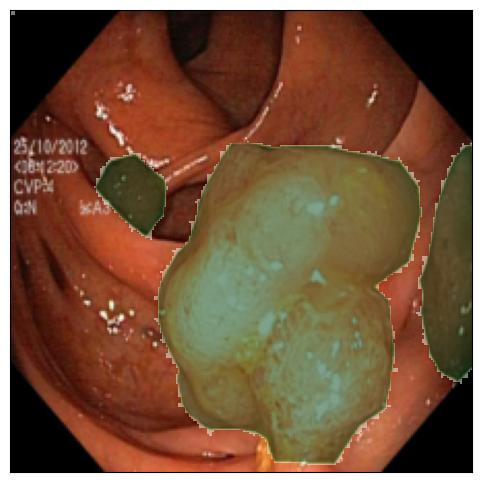

tensor(46)
Q: Are there any instruments in the image? A: Tube


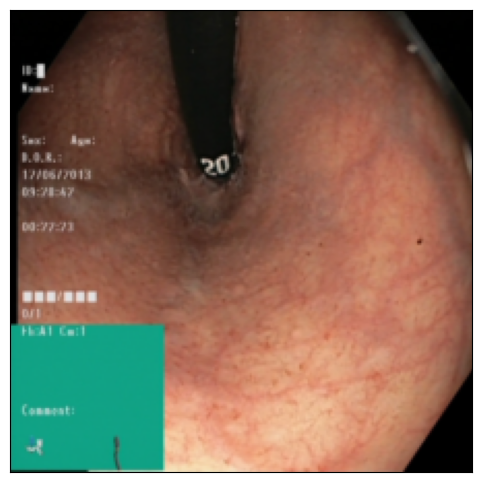

In [ ]:
gen_img(train_loader , 2)

# VQA Model Building

In [ ]:
class VQAModel(nn.Module):
    def __init__(self, num_classes):
        super(VQAModel, self).__init__()

        # Pre-trained encoder
        resnet = models.resnet50(pretrained=True) 
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])
        
        for param in self.encoder.parameters():
            param.requires_grad = False

        #for layer in self.encoder[-1:]:
            #for param in layer.parameters():
                    #param.requires_grad = True            
            
        self.conv = nn.Sequential(
            nn.Conv2d(2048, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(64, 10, kernel_size=3, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),            
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=503070, out_features=256),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.fc2 = nn.Linear(in_features=256, out_features=num_classes)

    def forward(self, image, text_feature):

        #print(text_feature)
        
        #print(text_feature.shape)
        # Extract image features using CNN
        cnn_features = self.encoder(image)
        #print(cnn_features.shape)
    
        cnn_features = self.conv(cnn_features)
        #print(cnn_features.shape)
        
        # to make it three dims and can concate with text feature
        cnn_features = cnn_features.view(cnn_features.shape[0], cnn_features.shape[1], -1)
        #print(cnn_features.shape)
        
        combined_features = torch.cat([cnn_features, text_feature], dim=2)
        #print(combined_features.shape)
        
        # Flatten
        combined_features = combined_features.view(combined_features.size(0), -1)
        #print(combined_features.shape)
    
        # Pass the concatenated features through MLP
        combined_features = self.fc1(combined_features)
        output = self.fc2(combined_features)
        #print(output.shape)

        return output

In [ ]:
def preprocess_question(question, tokenizer, max_length = 64):
    # Tokenize question
    tokens = tokenizer.encode_plus(question, padding='max_length', max_length = max_length, truncation = True)
    #print(tokens)
    input_ids = torch.tensor(tokens['input_ids'])
    attention_mask = torch.tensor(tokens['attention_mask'])
    return input_ids, attention_mask

# __VQA Training__

In [ ]:
num_classes = len(merge['answer_class'].unique())
print(f"Number of classes : {num_classes}")

Number of classes : 58


In [ ]:
model = VQAModel(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 5e-5)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.9)

#NLP_model = GPT2LMHeadModel.from_pretrained('gpt2')

In [ ]:
# Model Parameters
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} model parameters")

129,986,712 model parameters


In [ ]:
print(f"Is my model in GPU? : {next(model.parameters()).is_cuda}\n")

# GPU memory cache size
if torch.cuda.is_available():
    print(f"The allocated memory in the GPU for the model : {torch.cuda.memory_allocated()/(1024 * 1024):.3f}MB")

Is my model in GPU? : True

The allocated memory in the GPU for the model : 586.498MB


In [ ]:
def update_plots(loss_values_train, loss_values_val, acc_values_train, acc_values_val, print_messages):
    clear_output(wait = True)

    # Display print messages
    for message in print_messages:
        print(message)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 5))

    # Plot loss values
    ax1.plot(range(1, len(loss_values_train) + 1), loss_values_train, label = "Train Loss")
    ax1.plot(range(1, len(loss_values_val) + 1), loss_values_val, label = "Validation Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.set_title("Loss values")
    ax1.grid(linestyle = "--", linewidth = 0.5)

    # Plot IoU values
    ax2.plot(range(1, len(acc_values_train) + 1), acc_values_train, label = "Train Acc")
    ax2.plot(range(1, len(acc_values_val) + 1), acc_values_val, label = "Validation Acc")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Acc")
    ax2.legend()
    ax2.set_title("Acc values")
    ax2.grid(linestyle = "--", linewidth = 0.5)

    plt.show()

In [ ]:
'''
temp_train_df = merge[merge['ImageID'].isin(train_ID[:61])]
temp_test_df = merge[merge['ImageID'].isin(test_ID[:16])]

temp_train_set = Importdata(temp_train_df, transforms = img_transform)
temp_test_set = Importdata(temp_test_df, transforms = img_transform)
temp_train_loader = torch.utils.data.DataLoader(dataset=temp_train_set, batch_size=batch_size, shuffle=True)
temp_test_loader = torch.utils.data.DataLoader(dataset=temp_test_set, batch_size=batch_size, shuffle=False)
'''

In [ ]:
# The following must with the def function to make sure each batch has the fixed length of tokenizer
NLP_model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    NLP_model.resize_token_embeddings(len(tokenizer))

Using pad_token, but it is not set yet.


In [ ]:
 # Release GPU memory cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [ ]:
epochs = 50

In [ ]:
def time_to_seconds(time_string):
    '''
    Input Format :  'hh:mm:ss'
    '''
    time_components = time_string.split(':')
    hours = int(time_components[0])
    minutes = int(time_components[1])
    seconds = int(time_components[2])
    time_in_seconds = hours * 3600 + minutes * 60 + seconds

    return time_in_seconds

In [ ]:
from_beginning = False


	 ****** Training has begun. ******

Epoch: 001 | Learning Rate : 1.00000E-04 | Train Loss: 3.5643 | Val Loss: 1.7251 | Train Acc: 32.9239 | Val Acc: 53.4351 | Time: 00:14:02
Epoch: 002 | Learning Rate : 9.00000E-05 | Train Loss: 1.7123 | Val Loss: 1.4157 | Train Acc: 50.9381 | Val Acc: 52.4718 | Time: 00:27:39
Epoch: 003 | Learning Rate : 8.10000E-05 | Train Loss: 1.4847 | Val Loss: 1.2427 | Train Acc: 55.2644 | Val Acc: 66.5394 | Time: 00:44:11
Epoch: 004 | Learning Rate : 7.29000E-05 | Train Loss: 1.3387 | Val Loss: 1.1312 | Train Acc: 59.5234 | Val Acc: 68.6296 | Time: 01:08:54
Epoch: 005 | Learning Rate : 6.56000E-05 | Train Loss: 1.2293 | Val Loss: 1.0268 | Train Acc: 62.6343 | Val Acc: 71.1014 | Time: 01:32:21
Epoch: 006 | Learning Rate : 5.90000E-05 | Train Loss: 1.1531 | Val Loss: 0.9684 | Train Acc: 64.8953 | Val Acc: 74.3366 | Time: 01:46:18
Epoch: 007 | Learning Rate : 5.31000E-05 | Train Loss: 1.0913 | Val Loss: 0.9034 | Train Acc: 66.8484 | Val Acc: 72.2283 | Time: 02:00

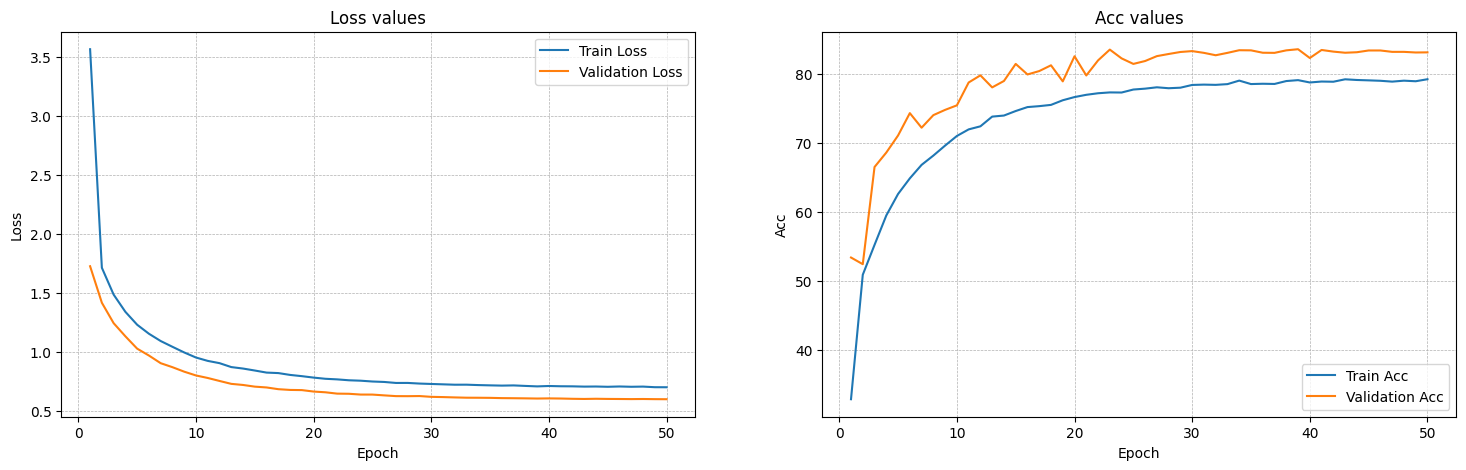

In [ ]:
# Training process
if from_beginning:
    epoch_list = []
    loss_values_train = []
    loss_values_val = []
    acc_train = []
    acc_val = []
    history_learning_rate = []
    epoch_time = []

    print_messages = ['\n\t ****** Training has begun. ******\n']

    starting_epoch = 1
    print(f"Starting epoch : {starting_epoch}")

    start = timer()
    dt = 0


else:
    my_outcomes = pd.read_csv("VQAModel_outcomes.csv")
    # print(my_outcomes)

    epoch_list = my_outcomes.Epoch.T.tolist()
    loss_values_train = my_outcomes.Train_Loss.T.tolist()
    loss_values_val = my_outcomes.Validation_Loss.T.tolist()
    acc_train = my_outcomes.Train_Accuracy.T.tolist()
    acc_val = my_outcomes.Validation_Accuracy.T.tolist()
    history_learning_rate = my_outcomes.Learning_Rate.T.tolist()
    epoch_time = my_outcomes.Time.T.tolist()

    print_messages = ['\n\t ****** Training has begun. ******\n']
    for i in range(0, epoch_list[-1]):
        message = f'Epoch: {epoch_list[i]:03} | Learning Rate : {history_learning_rate[i]:.5E} | Train Loss: {loss_values_train[i]:.4f} | Val Loss: {loss_values_val[i]:.4f} | Train Acc: {acc_train[i]:.4f} | Val Acc: {acc_val[i]:.4f} | Time: {epoch_time[i]}'
        print_messages.append(message)

    starting_epoch = epoch_list[-1] + 1
    print(f"Starting epoch : {starting_epoch}")

    start = timer()
    dt = time_to_seconds(epoch_time[-1])


# Update the plots
update_plots(loss_values_train, loss_values_val, acc_train, acc_val, print_messages)



for epoch in range(starting_epoch, epochs + 1):
    epoch_list.append(epoch_list[-1] + 1)
    model.train()
    train_correct, train_loss, num_img, num_batch = 0, 0, 0, 0

    history_learning_rate.append(optimizer.param_groups[0]['lr'])

    for batch_idx, (image, mask, question, answer) in enumerate(train_loader): # Remember to transfer it to 'train_loader'
        
        answer = answer.long()
        image, answer = image.to(device), answer.to(device)
        
        # Preprocess question
        question = list(question)  # Convert tensor to nested list
        inputs = tokenizer(question, padding='max_length', max_length=10, truncation=True, return_tensors='pt')
        # Get text features
        feature = NLP_model(**inputs)[0].to(device)
        
        # Normalize the feature vector
        feature = F.normalize(feature, p=2, dim=1)
        #print(feature)
        
        
        num_img+= image.shape[0]
        num_batch+=1
                        
        # Forward pass
        output = model(image, feature)
        predict = output.argmax(dim=1, keepdim=True) 
        #print(predict)
        loss = criterion(output, answer)
        optimizer.zero_grad()
        
        '''
        l2_regularization = torch.tensor(0.).to('cuda')
        for param in model.parameters():
            l2_regularization += torch.norm(param, p=2)
        loss += 0.01 * l2_regularization
        '''

        # Backward pass and optimization
        loss.backward()

        # Gradient Clipping
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 10.0) 

        optimizer.step()
            
        train_correct += predict.eq(answer.view_as(predict)).sum().item()
        train_loss+=loss.item()

    loss_values_train.append(train_loss/num_batch )
    acc_train.append(train_correct/num_img*100)

        
    model.eval()
    test_correct, test_loss, test_num_img, test_num_batch = 0, 0, 0, 0

    for batch_idx, (image, mask, question, answer) in enumerate(test_loader): # Remember to transfer it to 'test_loader'
        
        answer = answer.long()
        image, mask, answer = image.to(device), mask.to(device), answer.to(device)
        
        # Preprocess question
        question = list(question)  # Convert tensor to nested list
        inputs = tokenizer(question, padding='max_length', max_length=10, truncation=True, return_tensors='pt')
        # Get text features
        feature = NLP_model(**inputs)[0].to(device)
        #print(feature)
        feature = F.normalize(feature, p=2, dim=1)
        
        test_num_img+= image.shape[0]
        test_num_batch+=1
                        
        output = model(image, feature)
        predict = output.argmax(dim=1, keepdim=True)                
        loss = criterion(output, answer)

            
        test_correct += predict.eq(answer.view_as(predict)).sum().item()
        test_loss+=loss.item()


    loss_values_val.append(test_loss/test_num_batch)
    acc_val.append(test_correct/test_num_img*100)
    
    epoch_time.append(timedelta(seconds = int(timer() - start) + dt))
    message = f'Epoch: {epoch:03} | Learning Rate : {history_learning_rate[-1]:.5E} | Train Loss: {loss_values_train[-1]:.4f} | Val Loss: {loss_values_val[-1]:.4f} | Train Acc: {acc_train[-1]:.4f} | Val Acc: {acc_val[-1]:.4f} | Time: {epoch_time[-1]}'
    print_messages.append(message)
    
    # Update the plots
    update_plots(loss_values_train, loss_values_val, acc_train, acc_val, print_messages)

    # Scheduler of learning rate
    scheduler.step()

# Wrap up the training process
end = timer()
message = '\n\n\t ****** Training has finished. ******\n'
print_messages.append(message)
print(message)
message = f'\tTraining time: {timedelta(seconds = int(end - start) + dt)} [hh:mm:ss]'
print_messages.append(message)
print(message)

# Update the plots
update_plots(loss_values_train, loss_values_val, acc_train, acc_val, print_messages)

# Release GPU memory cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# creating the DataFrame
outcomes = pd.DataFrame(
    {'Epoch': epoch_list,
        'Learning_Rate': history_learning_rate,
        'Train_Loss': loss_values_train,
        'Validation_Loss': loss_values_val,
        'Train_Accuracy': acc_train,
        'Validation_Accuracy': acc_val,
        'Time': epoch_time,
    })

# saving the DataFrame as a CSV file
outcomes.to_csv(f'{model.__class__.__name__}_outcomes.csv', index = False)

model_scripted = torch.jit.script(model) # Export to TorchScript using script
model_name = model.__class__.__name__
model_scripted.save(model_name + ".pt")

#### __Plot of the Loss and the Accuracy History__

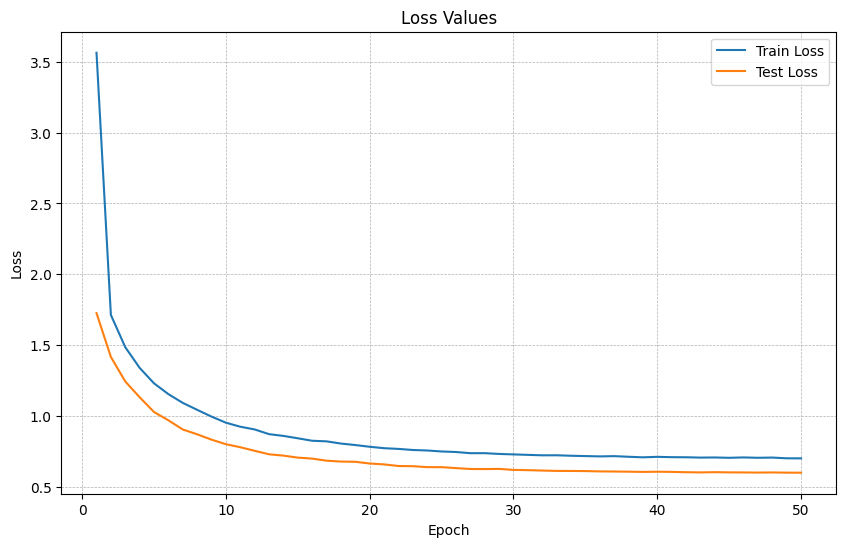

In [ ]:
# Create the first plot for loss values
fig1, ax1 = plt.subplots(figsize = (10, 6))

ax1.plot(range(1, len(loss_values_train) + 1), loss_values_train, label = 'Train Loss')
ax1.plot(range(1, len(loss_values_val) + 1), loss_values_val, label = 'Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss Values')
ax1.grid(linestyle='--', linewidth=0.5)

plt.show()

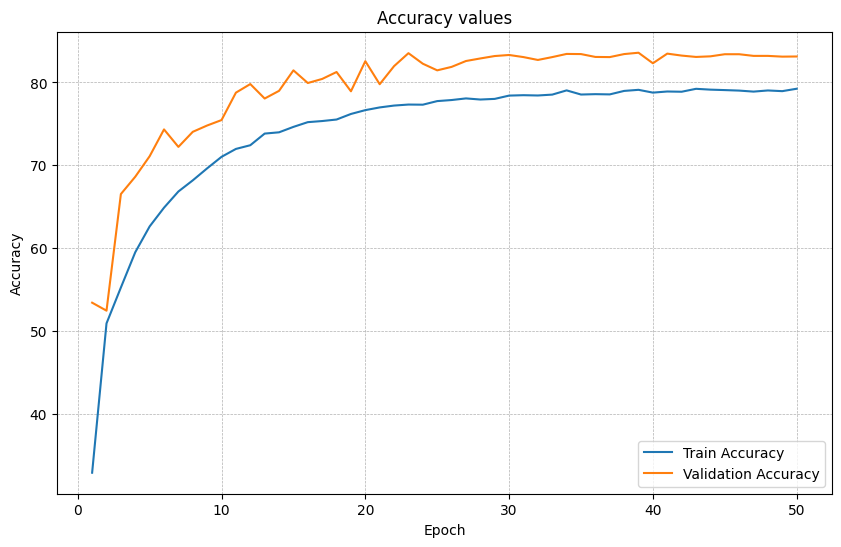

In [ ]:
# Create the second plot for accuracy values
fig2, ax2 = plt.subplots(figsize = (10, 6))

ax2.plot(range(1, len(acc_train) + 1), acc_train, label = "Train Accuracy")
ax2.plot(range(1, len(acc_val) + 1), acc_val, label = "Validation Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.set_title("Accuracy values")
ax2.grid(linestyle = "--", linewidth = 0.5)

plt.show()

#### __History of the Learning Rate__

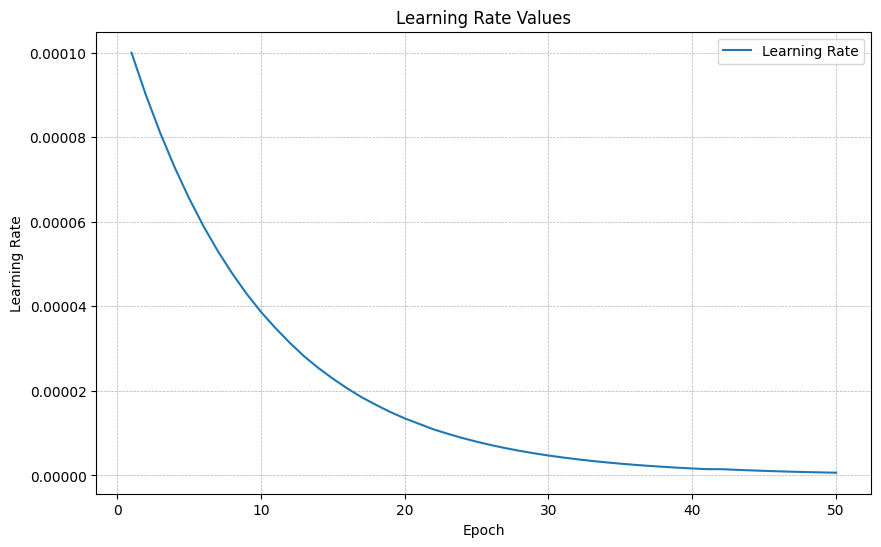

In [ ]:
# Plot learning rate values
plt.figure(figsize = (10, 6))
plt.plot(range(1, len(history_learning_rate) + 1), history_learning_rate, label = 'Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.title('Learning Rate Values')
plt.grid(linestyle = '--', linewidth = 0.5)

plt.show()

## __Binary Classifier__

In [ ]:
train_seg_df = df[df['ImageID'].isin(train_ID)]
test_seg_df = df[df['ImageID'].isin(test_ID)]

batch_size= 4
train_set_seg = Importdata_segment(train_seg_df, train = True)
test_set_seg = Importdata_segment(test_seg_df)
train_loader_seg = torch.utils.data.DataLoader(dataset=train_set_seg, batch_size=batch_size, shuffle=True)
test_loader_seg = torch.utils.data.DataLoader(dataset=test_set_seg, batch_size=batch_size, shuffle=False)

tensor(1)


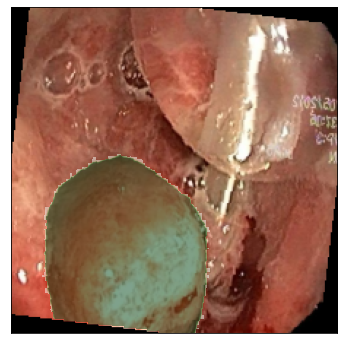

tensor(1)


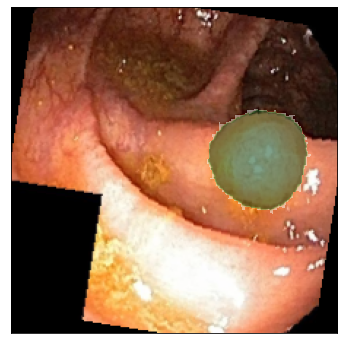

tensor(0)


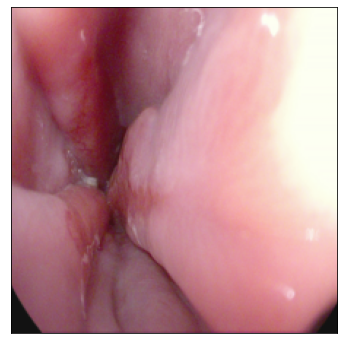

tensor(1)


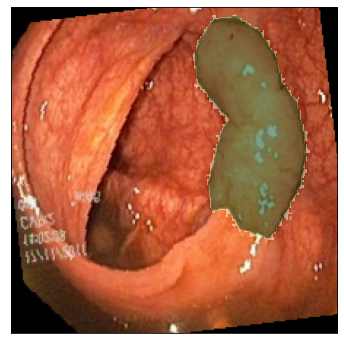

In [ ]:
gen_img(train_loader_seg , 4, seg=True)

## Train a classifer to detect whether there has an object

In [27]:
class BinaryClassification(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, num_classes=2):
        super(BinaryClassification, self).__init__()
        
        # Pre-trained encoder
        resnet = models.resnet50(pretrained=True)
    
        self.encoder = nn.Sequential(*list(resnet.children())[:-2]) # total has 9 layers
        
        # Freeze all layers except the last few layers
        for layer in self.encoder[-3:]:
            for param in layer.parameters():
                    param.requires_grad = True
        
        self.binary_classifier = nn.Sequential(nn.Linear(100352, 2))

    def forward(self, x):
        # Encoder
        feature = self.encoder(x)
        feature = torch.flatten(feature, 1)
        # Binary classification
        binary_output = self.binary_classifier(feature)
        # Only return the class 1 probability
        binary_output = torch.sigmoid(binary_output)[:, 1]

        return binary_output

In [7]:
model = BinaryClassification().to('cuda')


# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6 , weight_decay=5e-3)

# Define your scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

criterion = nn.BCELoss()

In [8]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
from datetime import datetime
start_time = datetime.now()

# Train the model
num_epochs = 30
all_trainloss = []
all_testloss = []
all_train_acc = []
all_test_acc = []

for epoch in range(num_epochs):
    model.train()

    train_correct = 0
    train_count = 0
    train_loss = 0

    for image, mask, bi_label in train_loader_seg:
        # Forward pass
        image, mask, bi_label = image.to('cuda', dtype=torch.float), mask.to('cuda', dtype=torch.float), bi_label.to('cuda', dtype=torch.float)
        optimizer.zero_grad()
        class_pred = model(image)
        #print(class_pred)
        classloss = criterion(class_pred, bi_label)
        class_predict = (class_pred > 0.5).int()
        
        #print(class_predict, bi_label)
        train_correct += class_predict.eq(bi_label.view_as(class_predict)).sum().item()
        train_count += bi_label.size(0)
        train_loss += classloss.item()
        
        l2_regularization = torch.tensor(0.).to('cuda')
        for param in model.parameters():
            l2_regularization += torch.norm(param, p=2)
        classloss += 0.01 * l2_regularization
             
        
        
        # Backward pass
        classloss.backward()
        optimizer.step()

    # Testing   
    model.eval()
    test_correct = 0
    test_count = 0
    test_loss = 0

    with torch.no_grad():
        for image, mask, bi_label in test_loader_seg:
            # Forward pass
            image, mask, bi_label = image.to('cuda', dtype=torch.float), mask.to('cuda', dtype=torch.float), bi_label.to('cuda', dtype=torch.float)
            class_pred = model(image)
            classloss = criterion(class_pred, bi_label)
            class_predict = (class_pred > 0.5).int()
            test_correct += class_predict.eq(bi_label.view_as(class_predict)).sum().item()
            test_count += bi_label.size(0)
            test_loss += classloss.item()

    train_loss /= len(train_loader_seg)
    test_loss /= len(test_loader_seg)
    train_acc = 100. * train_correct / len(train_loader_seg.dataset)
    test_acc = 100. * test_correct / len(test_loader_seg.dataset)

    all_trainloss.append(train_loss)
    all_testloss.append(test_loss)
    all_train_acc.append(train_acc)
    all_test_acc.append(test_acc)

    scheduler.step()

    if test_acc >= 80 or (epoch+1) % 100 == 0:
        PATH = f'binaryclass_{epoch+1}_v5.pth'
        torch.save(model.state_dict(), PATH)

    # Print the loss and accuracy
    print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}, Acc: {train_acc:.4f}%, testLoss: {test_loss:.4f}, testAcc: {test_acc:.4f}%")

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1, Loss: 0.6186, Acc: 65.7059%, testLoss: 0.5291, testAcc: 72.3333%
Epoch 2, Loss: 0.5324, Acc: 72.4706%, testLoss: 0.4527, testAcc: 85.3333%
Epoch 3, Loss: 0.4625, Acc: 79.2941%, testLoss: 0.3984, testAcc: 87.3333%
Epoch 4, Loss: 0.4193, Acc: 83.3529%, testLoss: 0.3336, testAcc: 92.0000%
Epoch 5, Loss: 0.3756, Acc: 85.1765%, testLoss: 0.2810, testAcc: 93.6667%
Epoch 6, Loss: 0.3458, Acc: 87.5294%, testLoss: 0.2733, testAcc: 94.3333%
Epoch 7, Loss: 0.3213, Acc: 87.9412%, testLoss: 0.2721, testAcc: 92.0000%
Epoch 8, Loss: 0.2951, Acc: 89.4118%, testLoss: 0.2597, testAcc: 92.6667%
Epoch 9, Loss: 0.2848, Acc: 89.1176%, testLoss: 0.2341, testAcc: 94.0000%
Epoch 10, Loss: 0.2701, Acc: 90.2353%, testLoss: 0.2113, testAcc: 95.3333%
Epoch 11, Loss: 0.2585, Acc: 89.7647%, testLoss: 0.2197, testAcc: 93.6667%
Epoch 12, Loss: 0.2588, Acc: 90.4118%, testLoss: 0.1999, testAcc: 93.3333%
Epoch 13, Loss: 0.2428, Acc: 90.7647%, testLoss: 0.1837, testAcc: 95.3333%
Epoch 14, Loss: 0.2303, Acc: 91.52

In [71]:
bi_res

,Train Loss,Train Acc,Test Loss,Test Acc
0,0.6186,65.7059,0.5291,72.3333
1,0.5324,72.4706,0.4527,85.3333
2,0.4625,79.2941,0.3984,87.3333
3,0.4193,83.3529,0.3336,92.0000
4,0.3756,85.1765,0.2810,93.6667
5,0.3458,87.5294,0.2733,94.3333
6,0.3213,87.9412,0.2721,92.0000
7,0.2951,89.4118,0.2597,92.6667
8,0.2848,89.1176,0.2341,94.0000
9,0.2701,90.2353,0.2113,95.3333


Text(0.5, 0, 'epoch')

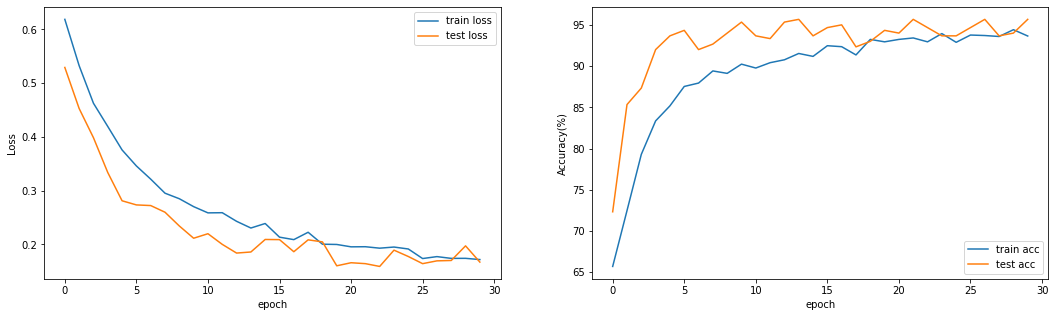

In [79]:
x = [i for i in range(30)]
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
bi_res = pd.read_csv('Binary_classification_history.csv')
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(x, bi_res.iloc[:,0])
plt.plot(x, bi_res.iloc[:,2])
plt.legend(['train loss','test loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')


plt.subplot(122)
plt.plot(x, bi_res.iloc[:,1])
plt.plot(x, bi_res.iloc[:,3])
plt.legend(['train acc','test acc'])
plt.ylabel('Accuracy(%)')
plt.xlabel('epoch')

## Train a segmentation model

In [ ]:
train_seg_df=df[(df['ImageID'].isin(train_ID))&(df['mask']==1)]
test_seg_df=df[(df['ImageID'].isin(test_ID))&(df['mask']==1)]

batch_size= 4
train_set_seg = Importdata_segment(train_seg_df, train = True)
test_set_seg = Importdata_segment(test_seg_df)
train_loader_seg = torch.utils.data.DataLoader(dataset=train_set_seg, batch_size=batch_size, shuffle=True)
test_loader_seg = torch.utils.data.DataLoader(dataset=test_set_seg, batch_size=batch_size, shuffle=False)

In [28]:
class Decoderblock(nn.Module):
    def __init__(self, in_channels, middle):
        super(Decoderblock, self).__init__()
        middle_channels = int(in_channels / middle)
        self.decode = nn.Sequential(nn.ConvTranspose2d(in_channels, in_channels, kernel_size=3, stride=3, output_padding=2),
                                    nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(middle_channels),
                                    nn.ReLU(inplace=True),)

    def forward(self, x):
        return self.decode(x)
    
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(SegNet, self).__init__()
        
        # Pre-trained encoder
        resnet = models.resnet50(pretrained=True)
    
            
        self.encoder = nn.Sequential(*list(resnet.children())[:-2]) # total has 9 layers
        
        # Freeze all layers except the last few layers
        for layer in self.encoder[-3:]:
            for param in layer.parameters():
                    param.requires_grad = True
        
        self.last_dec= nn.Sequential(nn.ConvTranspose2d(64, 64, kernel_size=10, stride=1, output_padding=0),
                                    nn.Conv2d(64, 1, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(1),
                                    nn.ReLU(inplace=True),)
        
        # Decoder layers
        self.dec1 = Decoderblock(2048,4)
        self.dec2 = Decoderblock(512,2)
        self.dec3 = Decoderblock(256,4)
        
    def forward(self, x):
        # Encoder
        feature = self.encoder(x)
        #print(feature.shape)

        
        # Decoder
        dec1 = self.dec1(feature)
        #print(dec1.shape)
        dec2 = self.dec2(dec1)
        #print(dec2.shape)
        dec3 = self.dec3(dec2)
        #print(dec3.shape) 
        dec4 = self.last_dec(dec3)
        #print(dec4.shape) 
        
        return dec4

In [10]:
model = SegNet().to('cuda')


# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4 , weight_decay=5e-4)

# Define your scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

criterion = nn.BCEWithLogitsLoss()

In [11]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
def calioudice(pred_mask, true_mask):
    sum_iou = 0.0
    sum_dice = 0.0
    sigmoid = nn.Sigmoid()
    pred_mask = sigmoid(pred_mask)
    pred_mask = (pred_mask>0.5).float()
    #print(pred_mask.shape)
    #print(true_mask.shape)
    for i in range(pred_mask.shape[0]):
        
        intersect = torch.logical_and(pred_mask[i][0], true_mask[i][0])
        union = torch.logical_or(pred_mask[i][0], true_mask[i][0])
        
        epsilon = 1e-6
        intersect_sum = intersect.sum()
        union_sum = union.sum()
        if intersect_sum == 0:
            IoU = torch.tensor(0).long().to('cuda')
            dice= torch.tensor(0).long().to('cuda')
        else:
            IoU = intersect_sum/(union_sum + epsilon)
            A_B = (pred_mask[i][0]+true_mask[i][0]).sum()
            dice = 2*intersect_sum/(A_B + epsilon)
            
        #print(dice)
        
        sum_iou+=IoU
        sum_dice+=dice
    
    
    mean_iou=sum_iou/pred_mask.shape[0]
    mean_dice=sum_dice/pred_mask.shape[0]
    '''
    IoU_loss = 1-mean_iou
    Dice_loss = 1-mean_dice
    #print( IoU_loss, Dice_loss)
    loss = 0.5*IoU_loss + 0.5*Dice_loss
    '''
    
    return mean_iou, mean_dice

In [ ]:
from datetime import datetime
start_time = datetime.now()
# Train the model
num_epochs = 100
all_trainloss= []
all_testloss= []
all_train_iou=[]
all_test_iou=[]
all_train_dice=[]
all_test_dice=[]

for epoch in range(num_epochs):
    model.train()
    train_loss, test_loss = 0, 0
    train_iou, test_iou = 0, 0
    train_dice, test_dice = 0, 0
    for image, mask, bi_label in train_loader_seg:

        # Forward pass
        
        image, mask = image.to('cuda',dtype=torch.float), mask.to('cuda',dtype=torch.float)
        #print(image.shape)
        #print(mask.shape)
        #print(bi_label)
        optimizer.zero_grad()
        mask_pred = model(image)
        #print(mask_pred)
        
        #print(mask_pred.shape)
        mean_iou, mean_dice = calioudice(mask_pred, mask)
        
        mask = mask.view(mask.size(0), -1)
        mask_pred = mask_pred.view(mask_pred.size(0), -1)
        #print(mask.shape)
        #print(mask_pred.shape)

        loss = criterion(mask_pred, mask)

        # Backward pass
        
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()        
        train_dice+=mean_dice.item()
        train_iou+=mean_iou.item()
        
   
    # Testing   
    model.eval()
    for image, mask, bi_label in test_loader_seg:
        
        # Forward pass
        image, mask = image.to('cuda',dtype=torch.float), mask.to('cuda',dtype=torch.float)

        mask_pred = model(image)

        t_mean_iou, t_mean_dice = calioudice(mask_pred, mask)
        
        mask = mask.view(mask.size(0), -1)
        mask_pred = mask_pred.view(mask_pred.size(0), -1)       
        
        t_loss = criterion(mask_pred, mask)
        
        test_loss+=t_loss.item()   
        test_dice+=t_mean_dice.item()
        test_iou+=t_mean_iou.item()
        
    train_loss/=len(train_loader_seg)
    test_loss /= len(test_loader_seg)
    train_iou/=len(train_loader_seg)
    test_iou /= len(test_loader_seg)   
    train_dice/=len(train_loader_seg)
    test_dice /= len(test_loader_seg) 
        
    all_trainloss.append(train_loss)   
    all_testloss.append(test_loss)
    all_train_iou.append(train_iou*100)
    all_test_iou.append(test_iou*100)
    all_train_dice.append(train_dice*100)
    all_test_dice.append(test_dice*100)
    
    scheduler.step()
    
    if test_iou >= 0.7 or (epoch+1)%100 == 0:
        PATH = f'seg_{epoch+1}_v5.pth'
        torch.save(model.state_dict(), PATH)   


    # Print the loss and accuracy
    print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}, IoU:{train_iou*100:.4f}, Dice:{train_dice*100:.4f}, testLoss: { test_loss:.4f}, testIoU:{test_iou*100:.4f}, testDice:{test_dice*100:.4f}")

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1, Loss: 0.7077, IoU:19.2020, Dice:28.6492, testLoss: 0.6779, testIoU:27.6821, testDice:38.1375
Epoch 2, Loss: 0.6846, IoU:27.6903, Dice:39.6315, testLoss: 0.6669, testIoU:36.6802, testDice:48.7275
Epoch 3, Loss: 0.6758, IoU:34.9886, Dice:48.2102, testLoss: 0.6594, testIoU:39.2356, testDice:51.3926
Epoch 4, Loss: 0.6754, IoU:37.4335, Dice:51.2715, testLoss: 0.6625, testIoU:43.0936, testDice:57.5524
Epoch 5, Loss: 0.6781, IoU:35.7475, Dice:49.2079, testLoss: 0.6685, testIoU:40.7995, testDice:54.2417
Epoch 6, Loss: 0.6704, IoU:40.5532, Dice:54.5860, testLoss: 0.6638, testIoU:44.8609, testDice:59.6433
Epoch 7, Loss: 0.6674, IoU:43.4339, Dice:58.0226, testLoss: 0.6438, testIoU:55.6409, testDice:70.7594
Epoch 8, Loss: 0.6667, IoU:43.7613, Dice:58.2943, testLoss: 0.6585, testIoU:51.4030, testDice:67.7029
Epoch 9, Loss: 0.6643, IoU:44.0606, Dice:58.4750, testLoss: 0.6502, testIoU:50.9990, testDice:65.9595
Epoch 10, Loss: 0.6593, IoU:48.0199, Dice:63.0997, testLoss: 0.6471, testIoU:53.65

Epoch 81, Loss: 0.6244, IoU:72.9995, Dice:85.1789, testLoss: 0.6238, testIoU:73.7506, testDice:85.2491
Epoch 82, Loss: 0.6241, IoU:73.2747, Dice:85.3407, testLoss: 0.6175, testIoU:76.6987, testDice:88.1905
Epoch 83, Loss: 0.6250, IoU:73.0036, Dice:85.1413, testLoss: 0.6231, testIoU:74.4466, testDice:86.0383
Epoch 84, Loss: 0.6252, IoU:73.0844, Dice:85.2972, testLoss: 0.6205, testIoU:74.7044, testDice:86.2957
Epoch 85, Loss: 0.6244, IoU:72.3660, Dice:84.4143, testLoss: 0.6207, testIoU:74.4140, testDice:86.2677
Epoch 86, Loss: 0.6255, IoU:73.4630, Dice:85.6236, testLoss: 0.6230, testIoU:74.4925, testDice:86.3003
Epoch 87, Loss: 0.6242, IoU:71.9933, Dice:83.9849, testLoss: 0.6202, testIoU:73.5484, testDice:84.9726
Epoch 88, Loss: 0.6246, IoU:73.3471, Dice:85.4584, testLoss: 0.6211, testIoU:75.1364, testDice:86.5905
Epoch 89, Loss: 0.6235, IoU:73.1246, Dice:84.8593, testLoss: 0.6216, testIoU:75.0803, testDice:87.2264
Epoch 90, Loss: 0.6245, IoU:72.5672, Dice:84.4698, testLoss: 0.6220, test

In [64]:
seg_res

,Loss,IoU,Dice,testLoss,testIoU,testDice
0,0.7077,19.2020,28.6492,0.6779,27.6821,38.1375
1,0.6846,27.6903,39.6315,0.6669,36.6802,48.7275
2,0.6758,34.9886,48.2102,0.6594,39.2356,51.3926
3,0.6754,37.4335,51.2715,0.6625,43.0936,57.5524
4,0.6781,35.7475,49.2079,0.6685,40.7995,54.2417
...,...,...,...,...,...,...
95,0.6238,73.7048,85.7802,0.6209,74.6649,86.0202
96,0.6252,72.5112,84.6245,0.6231,75.7765,87.7758
97,0.6244,72.3605,84.4113,0.6191,73.3142,84.4885
98,0.6247,73.2764,85.3928,0.6188,75.0434,86.2658


Text(0.5, 0, 'epoch')

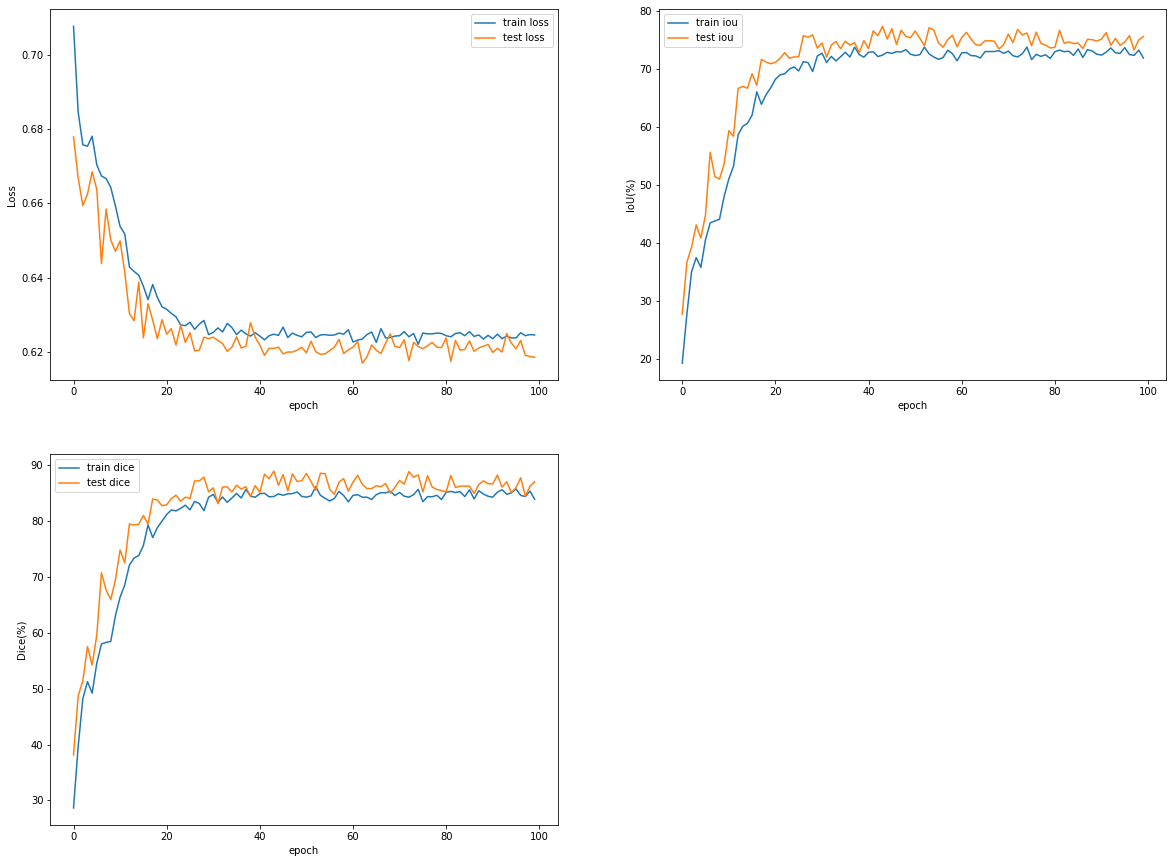

In [68]:
x = [i for i in range(100)]
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
seg_res = pd.read_csv('Segmentation_history.csv')
x = [i for i in range(100)]
plt.figure(figsize=(20,15))
plt.subplot(221)
plt.plot(x, seg_res.iloc[:,0])
plt.plot(x, seg_res.iloc[:,3])
plt.legend(['train loss','test loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')


plt.subplot(222)
plt.plot(x, seg_res.iloc[:,1])
plt.plot(x, seg_res.iloc[:,4])
plt.legend(['train iou','test iou'])
plt.ylabel('IoU(%)')
plt.xlabel('epoch')

plt.subplot(223)
plt.plot(x, seg_res.iloc[:,2])
plt.plot(x, seg_res.iloc[:,5])
plt.legend(['train dice','test dice'])
plt.ylabel('Dice(%)')
plt.xlabel('epoch')

# Show the prediction result

## VQA

In [ ]:
VQA = torch.load('/content/drive/MyDrive/Deep Learning/Final Project/VQAModel.pt')
VQA = VQA.to('cuda')  # Move the model to the GPU device
VQA.eval()

RecursiveScriptModule(
  original_name=VQAModel
  (encoder): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=BatchNorm2d)
    (2): RecursiveScriptModule(original_name=ReLU)
    (3): RecursiveScriptModule(original_name=MaxPool2d)
    (4): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=Bottleneck
        (conv1): RecursiveScriptModule(original_name=Conv2d)
        (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
        (conv2): RecursiveScriptModule(original_name=Conv2d)
        (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
        (conv3): RecursiveScriptModule(original_name=Conv2d)
        (bn3): RecursiveScriptModule(original_name=BatchNorm2d)
        (relu): RecursiveScriptModule(original_name=ReLU)
        (downsample): RecursiveScriptModule(
          original_name=Sequential
          (0): RecursiveSc

In [123]:
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=4, shuffle=False)
all_question=[]
all_true_answer, all_pred_Answer=[], []
all_pred_Answer=[]
for batch_idx, (image, mask, question, answer) in enumerate(test_loader):
    all_true_answer+=answer.tolist()
    answer = answer.long()
    image = image.to('cuda')  # Move the input tensor to the GPU device
    question = list(question)  # Convert tensor to nested list
    all_question+=question
    inputs = tokenizer(question, padding='max_length', max_length=10, truncation=True, return_tensors='pt')
    feature = NLP_model(**inputs)[0].to('cuda')
    feature = F.normalize(feature, p=2, dim=1)

    output = VQA(image, feature)
    predict = output.argmax(dim=1, keepdim=True)
    all_pred_Answer+=predict.tolist()

In [131]:
all_pred_Answer = [i[0] for i in all_pred_Answer]
pd.DataFrame(list(zip(all_question, all_true_answer, all_pred_Answer)),columns=['Question','True','Predict']).to_csv('VQA_predict.csv')

In [1]:
# import matplotlib.pyplot as plt

# test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=4, shuffle=False)

# all_true_answer, all_pred_Answer=[], []
# all_pred_Answer=[]
# for batch_idx, (image, mask, question, answer) in enumerate(test_loader):
#     all_true_answer.append(answer)
#     answer = answer.long()
#     image = image.to('cuda')  # Move the input tensor to the GPU device
#     question = list(question)  # Convert tensor to nested list
#     inputs = tokenizer(question, padding='max_length', max_length=10, truncation=True, return_tensors='pt')
#     feature = NLP_model(**inputs)[0].to('cuda')
#     feature = F.normalize(feature, p=2, dim=1)

#     output = VQA(image, feature)
#     predict = output.argmax(dim=1, keepdim=True)
#     all_pred_Answer.append(predict)

#     for i in range(len(predict)):

#         A = answer[i].item()
#         #all_true_answer.append(A)
#         pA = predict[i].item()
#         #all_pred_Answer.append(pA)
#         fig, ax = plt.subplots(figsize=(15,6))
#         mean = torch.Tensor([0.485, 0.456, 0.406])
#         std = torch.Tensor([0.229, 0.224, 0.225])
#         img_denorm = denormalize(image[i].clone(), mean, std)

#         ax.imshow(img_denorm.permute(1, 2, 0).to('cpu'), 'gray')
#         ax.set_title(f'Question: {question[i]}\nAns: {label_to_answer[A]} | Pred: {label_to_answer[pA]}')
#         ax.set_xticks([])
#         ax.set_yticks([])
#         plt.show()
      


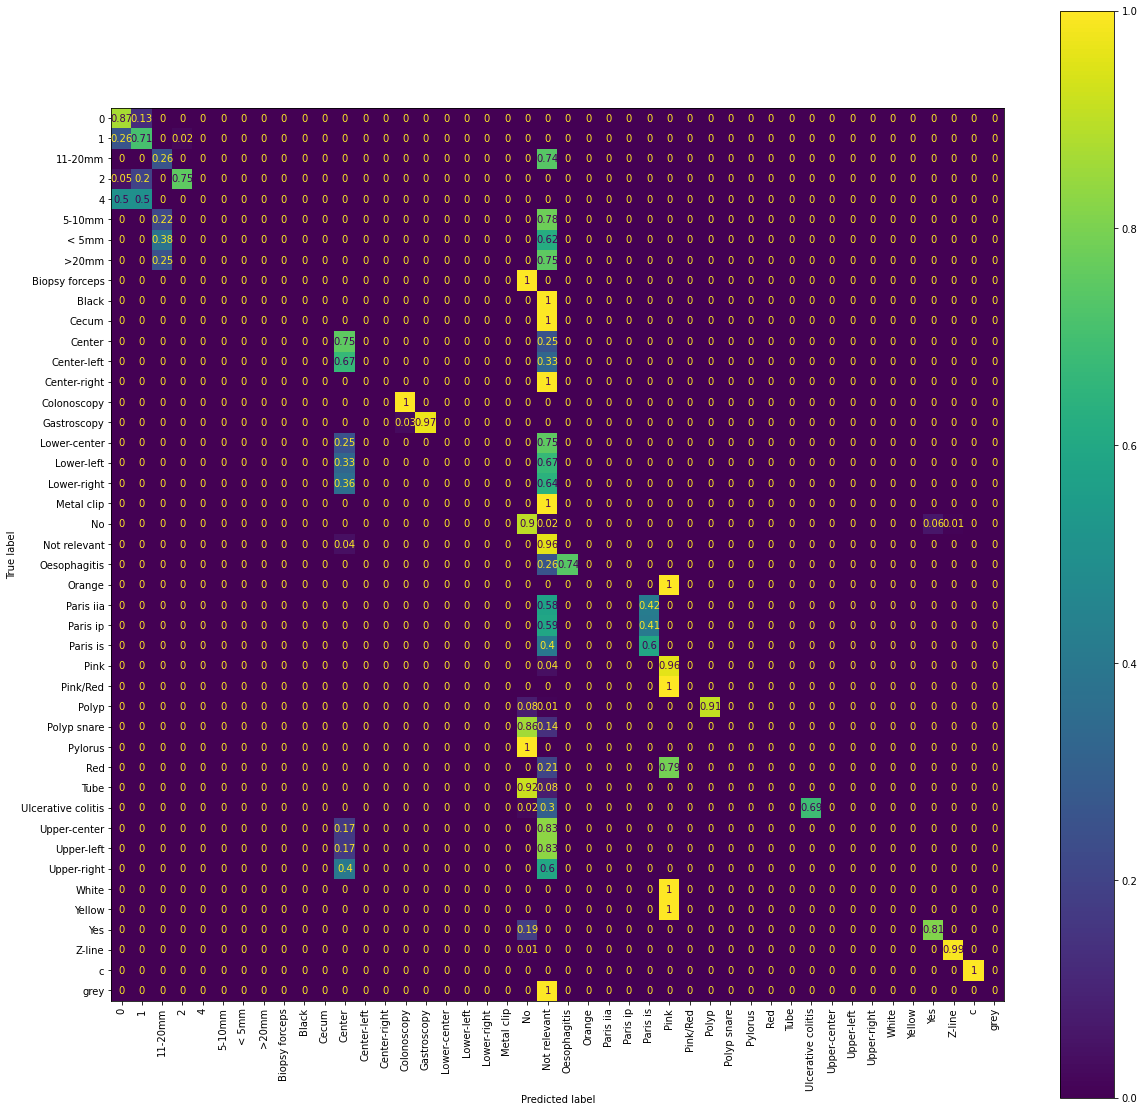

In [28]:
from sklearn import metrics

VQA_res = pd.read_csv('VQA_predict.csv')
confusion_matrix = metrics.confusion_matrix(VQA_res['True'], VQA_res['Predict'])

# Calculate the proportion of each class in the confusion matrix
class_counts = np.sum(confusion_matrix, axis=1)
proportion_matrix = np.round(confusion_matrix / class_counts[:, np.newaxis],2)

# Get the unique classes present in the testing set
unique_classes = np.unique(VQA_res['True'])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=proportion_matrix, display_labels=unique_classes)

fig, ax = plt.subplots(figsize=(20, 20))  # Adjust the figsize as desired

# Manually set the tick locations
ticks = np.arange(len(unique_classes))

# Set the tick labels using the class_mapping dictionary
labels = [label_to_answer[tick] for tick in unique_classes]

cm_display.plot(ax=ax)

# Set the tick locations and labels
ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=90)
ax.set_yticks(ticks)
ax.set_yticklabels(labels)

plt.show()


In [46]:
num_sample, acc=[],[]
for Q in VQA_res['Question'].unique():
    temp = VQA_res[VQA_res['Question']==Q]
    #print(temp)
    total=temp.shape[0]
    num_sample.append(total)
    count = 0
    for i in range(total):
        if temp.iloc[i,-2] == temp.iloc[i,-1]:
            count+=1
    acc.append(round(count/total,2))

pd.DataFrame(list(zip(VQA_res['Question'].unique(), num_sample, acc)),columns=['Question','# Sample','Accuracy'])


,Question,# Sample,Accuracy
0,Are there any abnormalities in the image?,300,0.82
1,Are there any anatomical landmarks in the image?,300,0.93
2,Are there any instruments in the image?,300,0.74
3,Have all polyps been removed?,300,0.95
4,How many findings are present?,300,0.77
5,How many instrumnets are in the image?,300,0.69
6,How many polyps are in the image?,300,0.93
7,Is there a green/black box artefact?,300,0.72
8,Is there text?,300,0.86
9,Is this finding easy to detect?,300,0.90


## Segmentation

In [29]:
bimodel = BinaryClassification().to('cuda')
bimodel.load_state_dict(torch.load('binaryclass_30_v5.pth'))
bimodel.eval()
segmodel = SegNet().to('cuda')
segmodel.load_state_dict(torch.load('seg_100_v5.pth'))
segmodel.eval()

SegNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 2

In [2]:
# test_seg_df=df[df['ImageID'].isin(test_ID)]
# test_set_seg = Importdata_segment(test_seg_df)
# test_loader_seg = torch.utils.data.DataLoader(dataset=test_set_seg, batch_size=4, shuffle=False)
# all_bi_label, bi_result=[], []
# with torch.no_grad():
#     for image, mask, bi_label in test_loader_seg:
#         image = image.to('cuda')
#         mask = mask.to('cuda')
#         all_bi_label+=bi_label.tolist()
#         bi_label = bi_label.to('cuda')

#         class_pred = bimodel(image)
#         class_predict = (class_pred > 0.5).int()
#         bi_result+=class_predict.tolist()

#         fig, axes = plt.subplots(4, 4, figsize=(18,20))

#         for i in range(class_predict.shape[0]):
            
#             # First column: Image
#             mean = torch.Tensor([0.485, 0.456, 0.406])
#             std = torch.Tensor([0.229, 0.224, 0.225])
#             img_denorm = denormalize(image[i].clone(), mean, std)
#             axes[i, 0].imshow(img_denorm.permute(1, 2, 0).cpu())
#             axes[i, 0].set_title('Image')

#             # Second column: Mask
#             if bi_label[i] == 1:
#                 axes[i, 1].imshow(mask[i].squeeze().cpu(), cmap='gray')
#                 axes[i, 1].set_title('True Mask')
#             else:
#                 axes[i, 1].text(0.5, 0.5, 'Ground Truth\nno object', fontsize=12, ha='center')

#             # Third column: Predicted Mask
#             if class_predict[i] == 1:
#                 mask_pred = segmodel(image[i].unsqueeze(0))
#                 sigmoid = nn.Sigmoid()
#                 pred_mask = sigmoid(mask_pred)
#                 pred_mask = (pred_mask>0.5).float()
#                 pred_mask = pred_mask.squeeze().cpu().numpy()
#                 axes[i, 2].imshow(pred_mask, cmap='gray')
#                 axes[i, 2].set_title('Predicted Mask')
                
#                 # Fourth column: Predicted Result
#                 pred_mask = np.ma.masked_where(pred_mask == 0, pred_mask)
#                 axes[i, 3].imshow(img_denorm.permute(1, 2, 0).cpu())
#                 axes[i, 3].imshow(pred_mask, alpha=0.4, cmap='BuGn_r')
#                 axes[i, 3].set_title('Predicted Results')
#             else:
#                 axes[i, 2].text(0.5, 0.5, 'Prediction\nno object', fontsize=12, ha='center')
#                 axes[i, 3].text(0.5, 0.5, 'Prediction\nno object', fontsize=12, ha='center')

#             # Remove x-axis and y-axis
#             axes[i, 0].axis('off')
#             axes[i, 1].axis('off')
#             axes[i, 2].axis('off')
#             axes[i, 3].axis('off')

#         # Manually adjust spacing between subplots
#         plt.subplots_adjust(wspace=0.05, hspace=0.2)  # Adjust the value of wspace as desired
#         plt.show()


            

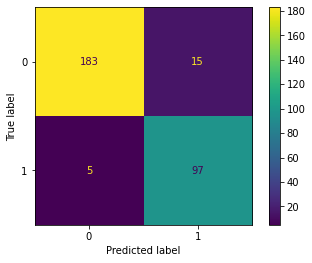

In [49]:
confusion_matrix = metrics.confusion_matrix(all_bi_label, bi_result)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0,1])

cm_display.plot()
plt.show()

* Ref:  
* https://medium.com/data-science-at-microsoft/visual-question-answering-with-multimodal-transformers-d4f57950c867  
* https://arxiv.org/pdf/1610.01465.pdf    (https://tryolabs.com/blog/2018/03/01/introduction-to-visual-question-answering)       
* https://arxiv.org/pdf/2303.04671.pdf  
* https://huggingface.co/transformers/v3.0.2/model_doc/gpt2.html#gpt2tokenizer
* https://medium.com/analytics-vidhya/visual-question-answering-with-various-feature-combinations-extensions-of-visual-question-940edbd84d82
* https://paperswithcode.com/paper/making-the-v-in-vqa-matter-elevating-the-role  
* https://arxiv.org/pdf/2111.10056.pdf  
* https://www.researchgate.net/publication/349068188_A-DenseUNet_Adaptive_Densely_Connected_UNet_for_Polyp_Segmentation_in_Colonoscopy_Images_with_Atrous_Convolution